# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
  """
  Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
  it for the linear classifier. These are the same steps as we used for the
  SVM, but condensed to a single function.  
  """
  # Load the raw CIFAR-10 data
  cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
  # subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]
  mask = np.random.choice(num_training, num_dev, replace=False)
  X_dev = X_train[mask]
  y_dev = y_train[mask]
  
  # Preprocessing: reshape the image data into rows
  X_train = np.reshape(X_train, (X_train.shape[0], -1))
  X_val = np.reshape(X_val, (X_val.shape[0], -1))
  X_test = np.reshape(X_test, (X_test.shape[0], -1))
  X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
  
  # Normalize the data: subtract the mean image
  mean_image = np.mean(X_train, axis = 0)
  X_train -= mean_image
  X_val -= mean_image
  X_test -= mean_image
  X_dev -= mean_image
  
  # add bias dimension and transform into columns
  X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
  X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
  X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
  X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
  
  return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape
print 'dev data shape: ', X_dev.shape
print 'dev labels shape: ', y_dev.shape

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [23]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print 'loss: %f' % loss
print 'sanity check: %f' % (-np.log(0.1))

loss: 2.321771
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** Since there are 10 classes, the probability for the starting point (random weights) should average 1/10 (or 0.1) for each class.


In [26]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 1e2)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -0.131424 analytic: -0.131424, relative error: 6.448960e-07
numerical: 0.920883 analytic: 0.920883, relative error: 7.319152e-08
numerical: -1.680632 analytic: -1.680632, relative error: 3.339796e-09
numerical: 0.096276 analytic: 0.096276, relative error: 6.857655e-07
numerical: 2.980047 analytic: 2.980046, relative error: 3.403773e-08
numerical: -0.050047 analytic: -0.050047, relative error: 1.026359e-07
numerical: 0.753745 analytic: 0.753745, relative error: 4.216848e-08
numerical: 3.984785 analytic: 3.984785, relative error: 1.417684e-08
numerical: -2.964942 analytic: -2.964942, relative error: 1.159979e-08
numerical: -0.529819 analytic: -0.529819, relative error: 4.387201e-08
numerical: 3.940007 analytic: 3.940007, relative error: 2.591752e-08
numerical: 2.017437 analytic: 2.017437, relative error: 2.247838e-08
numerical: 1.862717 analytic: 1.862717, relative error: 1.121857e-08
numerical: -0.318261 analytic: -0.318261, relative error: 2.365913e-08
numerical: -2.008291 a

In [42]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'naive loss: %e computed in %fs' % (loss_naive, toc - tic)

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print 'vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic)

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print 'Loss difference: %f' % np.abs(loss_naive - loss_vectorized)
print 'Gradient difference: %f' % grad_difference

naive loss: 2.321771e+00 computed in 0.080240s
vectorized loss: 2.321771e+00 computed in 0.010355s
Loss difference: 0.000000
Gradient difference: 0.000000


iteration 0 / 5000: loss 315.221192
iteration 100 / 5000: loss 209.696721
iteration 200 / 5000: loss 140.995218
iteration 300 / 5000: loss 94.718030
iteration 400 / 5000: loss 63.937209
iteration 500 / 5000: loss 43.402330
iteration 600 / 5000: loss 29.677729
iteration 700 / 5000: loss 20.547024
iteration 800 / 5000: loss 14.402678
iteration 900 / 5000: loss 10.278576
iteration 1000 / 5000: loss 7.627661
iteration 1100 / 5000: loss 5.667056
iteration 1200 / 5000: loss 4.495165
iteration 1300 / 5000: loss 3.662939
iteration 1400 / 5000: loss 3.169557
iteration 1500 / 5000: loss 2.793490
iteration 1600 / 5000: loss 2.461473
iteration 1700 / 5000: loss 2.394156
iteration 1800 / 5000: loss 2.383028
iteration 1900 / 5000: loss 2.135842
iteration 2000 / 5000: loss 2.096823
iteration 2100 / 5000: loss 2.100978
iteration 2200 / 5000: loss 2.042573
iteration 2300 / 5000: loss 2.041332
iteration 2400 / 5000: loss 2.002671
iteration 2500 / 5000: loss 2.035150
iteration 2600 / 5000: loss 2.062454


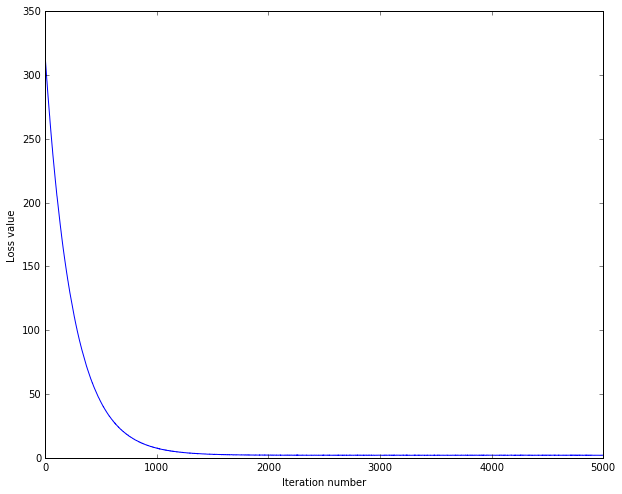

iteration 0 / 5000: loss 625.465885
iteration 100 / 5000: loss 280.468325
iteration 200 / 5000: loss 126.599562
iteration 300 / 5000: loss 57.777051
iteration 400 / 5000: loss 26.931625
iteration 500 / 5000: loss 13.139707
iteration 600 / 5000: loss 7.051043
iteration 700 / 5000: loss 4.282555
iteration 800 / 5000: loss 3.083359
iteration 900 / 5000: loss 2.504591
iteration 1000 / 5000: loss 2.275883
iteration 1100 / 5000: loss 2.207441
iteration 1200 / 5000: loss 2.139740
iteration 1300 / 5000: loss 2.060348
iteration 1400 / 5000: loss 2.003524
iteration 1500 / 5000: loss 2.097876
iteration 1600 / 5000: loss 2.002039
iteration 1700 / 5000: loss 2.113675
iteration 1800 / 5000: loss 2.076309
iteration 1900 / 5000: loss 2.133082
iteration 2000 / 5000: loss 2.068924
iteration 2100 / 5000: loss 2.132841
iteration 2200 / 5000: loss 2.138216
iteration 2300 / 5000: loss 2.070143
iteration 2400 / 5000: loss 2.057689
iteration 2500 / 5000: loss 2.073335
iteration 2600 / 5000: loss 2.089040
iter

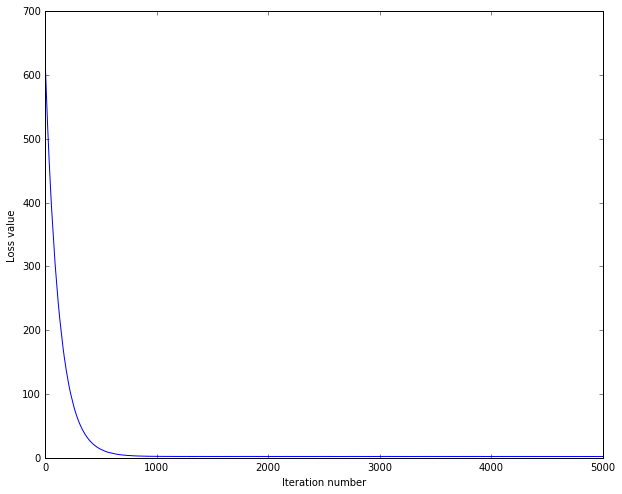

iteration 0 / 5000: loss 1249.168389
iteration 100 / 5000: loss 251.288484
iteration 200 / 5000: loss 51.939692
iteration 300 / 5000: loss 12.093163
iteration 400 / 5000: loss 4.161182
iteration 500 / 5000: loss 2.513110
iteration 600 / 5000: loss 2.166641
iteration 700 / 5000: loss 2.115450
iteration 800 / 5000: loss 2.141527
iteration 900 / 5000: loss 2.155357
iteration 1000 / 5000: loss 2.079041
iteration 1100 / 5000: loss 2.099965
iteration 1200 / 5000: loss 2.105261
iteration 1300 / 5000: loss 2.099060
iteration 1400 / 5000: loss 2.119154
iteration 1500 / 5000: loss 2.149359
iteration 1600 / 5000: loss 2.141338
iteration 1700 / 5000: loss 2.113394
iteration 1800 / 5000: loss 2.088079
iteration 1900 / 5000: loss 2.059404
iteration 2000 / 5000: loss 2.158952
iteration 2100 / 5000: loss 2.133459
iteration 2200 / 5000: loss 2.133443
iteration 2300 / 5000: loss 2.062365
iteration 2400 / 5000: loss 2.141291
iteration 2500 / 5000: loss 2.140737
iteration 2600 / 5000: loss 2.104845
iterat

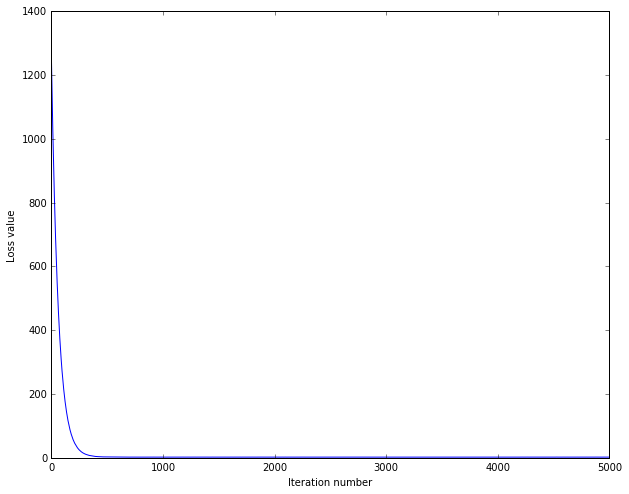

iteration 0 / 5000: loss 309.215209
iteration 100 / 5000: loss 138.415571
iteration 200 / 5000: loss 62.858729
iteration 300 / 5000: loss 29.232506
iteration 400 / 5000: loss 14.117919
iteration 500 / 5000: loss 7.421664
iteration 600 / 5000: loss 4.498737
iteration 700 / 5000: loss 3.065597
iteration 800 / 5000: loss 2.485695
iteration 900 / 5000: loss 2.243217
iteration 1000 / 5000: loss 2.126766
iteration 1100 / 5000: loss 2.095278
iteration 1200 / 5000: loss 2.089946
iteration 1300 / 5000: loss 2.030943
iteration 1400 / 5000: loss 2.036352
iteration 1500 / 5000: loss 2.044900
iteration 1600 / 5000: loss 2.074123
iteration 1700 / 5000: loss 1.956718
iteration 1800 / 5000: loss 2.002742
iteration 1900 / 5000: loss 1.951077
iteration 2000 / 5000: loss 1.965226
iteration 2100 / 5000: loss 2.062692
iteration 2200 / 5000: loss 2.004476
iteration 2300 / 5000: loss 2.010537
iteration 2400 / 5000: loss 1.947887
iteration 2500 / 5000: loss 1.985016
iteration 2600 / 5000: loss 2.027044
iterat

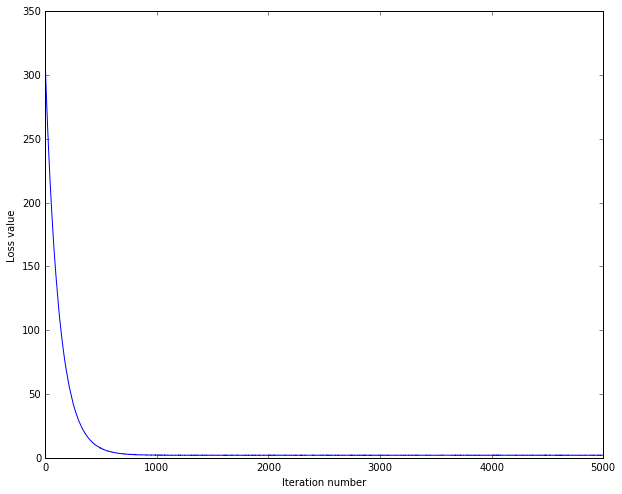

iteration 0 / 5000: loss 615.821122
iteration 100 / 5000: loss 124.408671
iteration 200 / 5000: loss 26.491229
iteration 300 / 5000: loss 6.909917
iteration 400 / 5000: loss 3.014670
iteration 500 / 5000: loss 2.253908
iteration 600 / 5000: loss 2.063478
iteration 700 / 5000: loss 1.970244
iteration 800 / 5000: loss 2.033074
iteration 900 / 5000: loss 2.106194
iteration 1000 / 5000: loss 2.090768
iteration 1100 / 5000: loss 1.964906
iteration 1200 / 5000: loss 2.131760
iteration 1300 / 5000: loss 2.091039
iteration 1400 / 5000: loss 2.115391
iteration 1500 / 5000: loss 2.076081
iteration 1600 / 5000: loss 2.039340
iteration 1700 / 5000: loss 2.094356
iteration 1800 / 5000: loss 2.069707
iteration 1900 / 5000: loss 1.992647
iteration 2000 / 5000: loss 2.082178
iteration 2100 / 5000: loss 2.064567
iteration 2200 / 5000: loss 2.008991
iteration 2300 / 5000: loss 2.002932
iteration 2400 / 5000: loss 2.181107
iteration 2500 / 5000: loss 2.080578
iteration 2600 / 5000: loss 2.092522
iteratio

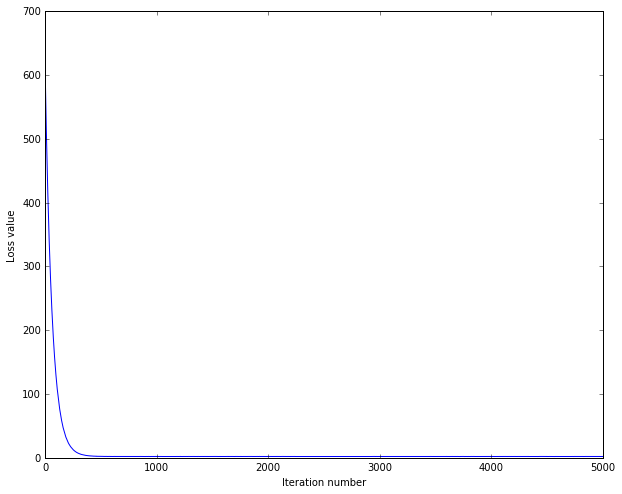

iteration 0 / 5000: loss 1238.176064
iteration 100 / 5000: loss 50.890090
iteration 200 / 5000: loss 4.074790
iteration 300 / 5000: loss 2.169436
iteration 400 / 5000: loss 2.141690
iteration 500 / 5000: loss 2.105335
iteration 600 / 5000: loss 2.153080
iteration 700 / 5000: loss 2.100559
iteration 800 / 5000: loss 2.120383
iteration 900 / 5000: loss 2.063254
iteration 1000 / 5000: loss 2.141015
iteration 1100 / 5000: loss 2.104387
iteration 1200 / 5000: loss 2.138805
iteration 1300 / 5000: loss 2.106530
iteration 1400 / 5000: loss 2.131849
iteration 1500 / 5000: loss 2.154540
iteration 1600 / 5000: loss 2.125564
iteration 1700 / 5000: loss 2.127557
iteration 1800 / 5000: loss 2.106851
iteration 1900 / 5000: loss 2.140245
iteration 2000 / 5000: loss 2.124287
iteration 2100 / 5000: loss 2.128777
iteration 2200 / 5000: loss 2.107688
iteration 2300 / 5000: loss 2.199179
iteration 2400 / 5000: loss 2.107011
iteration 2500 / 5000: loss 2.186308
iteration 2600 / 5000: loss 2.079388
iteration

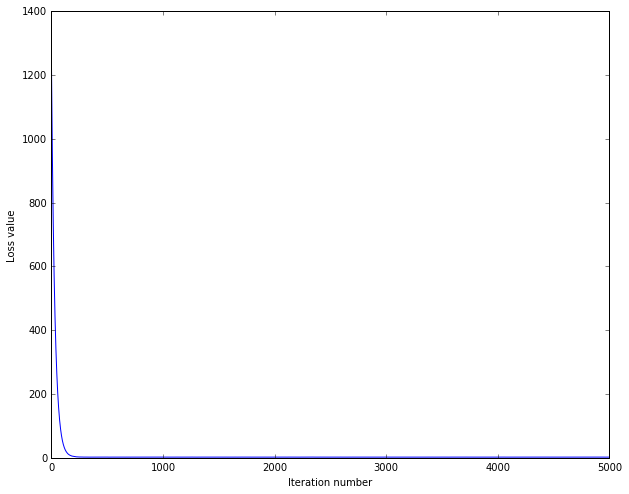

iteration 0 / 5000: loss 310.488593
iteration 100 / 5000: loss 63.066637
iteration 200 / 5000: loss 14.069644
iteration 300 / 5000: loss 4.387465
iteration 400 / 5000: loss 2.538597
iteration 500 / 5000: loss 2.151947
iteration 600 / 5000: loss 2.078908
iteration 700 / 5000: loss 1.962817
iteration 800 / 5000: loss 1.998308
iteration 900 / 5000: loss 1.959564
iteration 1000 / 5000: loss 2.088475
iteration 1100 / 5000: loss 2.015517
iteration 1200 / 5000: loss 1.991977
iteration 1300 / 5000: loss 2.009321
iteration 1400 / 5000: loss 2.043649
iteration 1500 / 5000: loss 1.987146
iteration 1600 / 5000: loss 1.973092
iteration 1700 / 5000: loss 2.008989
iteration 1800 / 5000: loss 2.101020
iteration 1900 / 5000: loss 2.000758
iteration 2000 / 5000: loss 2.012449
iteration 2100 / 5000: loss 2.032550
iteration 2200 / 5000: loss 2.070734
iteration 2300 / 5000: loss 1.929121
iteration 2400 / 5000: loss 1.994534
iteration 2500 / 5000: loss 2.050186
iteration 2600 / 5000: loss 1.963099
iteration

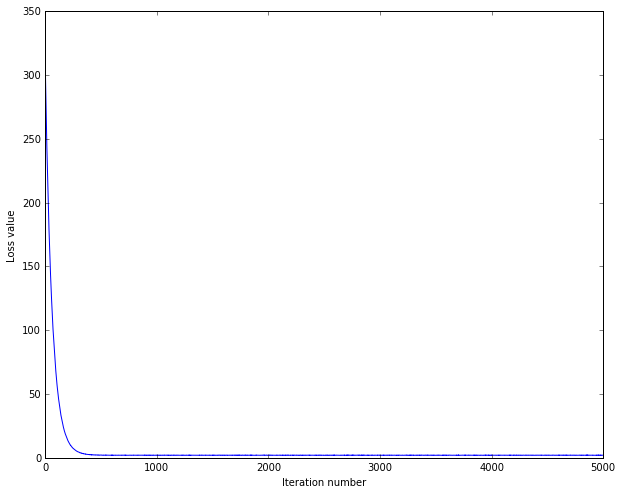

iteration 0 / 5000: loss 615.579991
iteration 100 / 5000: loss 26.197088
iteration 200 / 5000: loss 3.028981
iteration 300 / 5000: loss 2.082255
iteration 400 / 5000: loss 2.093795
iteration 500 / 5000: loss 2.078979
iteration 600 / 5000: loss 2.092651
iteration 700 / 5000: loss 2.100236
iteration 800 / 5000: loss 2.095239
iteration 900 / 5000: loss 2.066890
iteration 1000 / 5000: loss 2.085408
iteration 1100 / 5000: loss 2.069638
iteration 1200 / 5000: loss 2.064314
iteration 1300 / 5000: loss 2.088956
iteration 1400 / 5000: loss 2.076373
iteration 1500 / 5000: loss 2.010751
iteration 1600 / 5000: loss 2.043532
iteration 1700 / 5000: loss 2.050679
iteration 1800 / 5000: loss 2.076160
iteration 1900 / 5000: loss 2.105441
iteration 2000 / 5000: loss 2.060864
iteration 2100 / 5000: loss 2.033035
iteration 2200 / 5000: loss 2.018615
iteration 2300 / 5000: loss 1.988961
iteration 2400 / 5000: loss 2.066606
iteration 2500 / 5000: loss 1.989554
iteration 2600 / 5000: loss 2.088998
iteration 

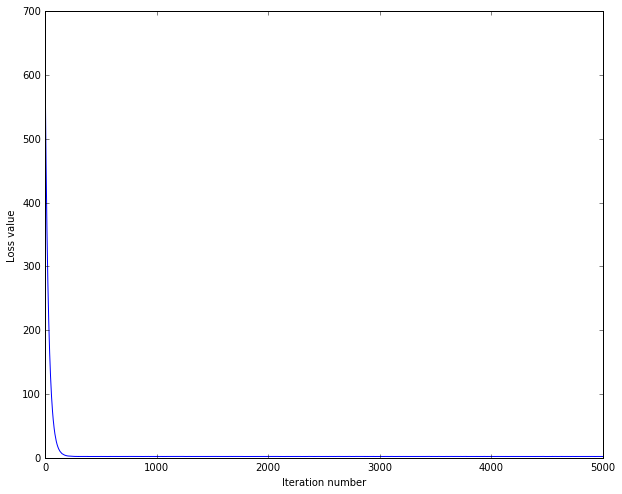

iteration 0 / 5000: loss 1247.469115
iteration 100 / 5000: loss 3.926139
iteration 200 / 5000: loss 2.121728
iteration 300 / 5000: loss 2.074128
iteration 400 / 5000: loss 2.115899
iteration 500 / 5000: loss 2.134902
iteration 600 / 5000: loss 2.155405
iteration 700 / 5000: loss 2.141700
iteration 800 / 5000: loss 2.111212
iteration 900 / 5000: loss 2.121301
iteration 1000 / 5000: loss 2.099641
iteration 1100 / 5000: loss 2.111987
iteration 1200 / 5000: loss 2.112345
iteration 1300 / 5000: loss 2.098573
iteration 1400 / 5000: loss 2.106702
iteration 1500 / 5000: loss 2.122051
iteration 1600 / 5000: loss 2.125016
iteration 1700 / 5000: loss 2.098400
iteration 1800 / 5000: loss 2.097723
iteration 1900 / 5000: loss 2.163814
iteration 2000 / 5000: loss 2.154265
iteration 2100 / 5000: loss 2.150514
iteration 2200 / 5000: loss 2.050683
iteration 2300 / 5000: loss 2.107652
iteration 2400 / 5000: loss 2.145743
iteration 2500 / 5000: loss 2.133352
iteration 2600 / 5000: loss 2.128990
iteration 

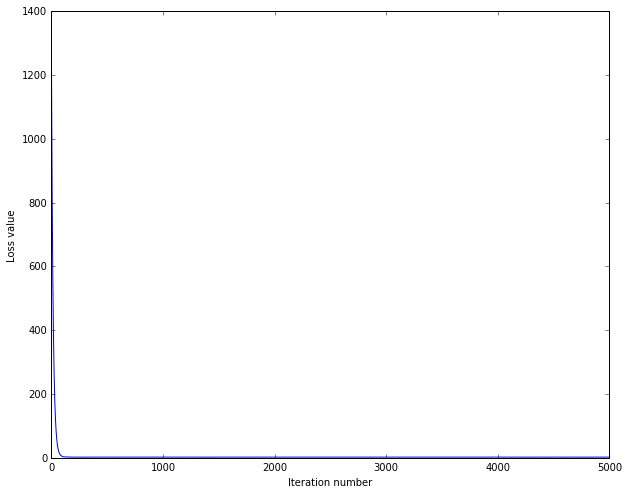

lr 1.000000e-07 reg 2.000000e+04 train accuracy: 0.358898 val accuracy: 0.372000
lr 1.000000e-07 reg 4.000000e+04 train accuracy: 0.331980 val accuracy: 0.346000
lr 1.000000e-07 reg 8.000000e+04 train accuracy: 0.316163 val accuracy: 0.327000
lr 2.000000e-07 reg 2.000000e+04 train accuracy: 0.358469 val accuracy: 0.364000
lr 2.000000e-07 reg 4.000000e+04 train accuracy: 0.340776 val accuracy: 0.361000
lr 2.000000e-07 reg 8.000000e+04 train accuracy: 0.317959 val accuracy: 0.326000
lr 4.000000e-07 reg 2.000000e+04 train accuracy: 0.354592 val accuracy: 0.371000
lr 4.000000e-07 reg 4.000000e+04 train accuracy: 0.332143 val accuracy: 0.350000
lr 4.000000e-07 reg 8.000000e+04 train accuracy: 0.313571 val accuracy: 0.324000
best validation accuracy achieved during cross-validation: 0.372000


In [61]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 2e-7, 4e-7]
regularization_strengths = [2e4, 4e4, 8e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
for lr in learning_rates:
    for reg in regularization_strengths:
        softmax = Softmax()
        loss_hist = softmax.train(X_train, y_train, learning_rate=lr, reg=reg,
                      num_iters=5000, verbose=True)
        y_train_pred = softmax.predict(X_train)
        train_accuracy = np.mean(y_train == y_train_pred)
        y_val_pred = softmax.predict(X_val)
        val_accuracy = np.mean(y_val == y_val_pred)
        results[(lr, reg)] = (train_accuracy, val_accuracy)
        if val_accuracy > best_val:
            print 'Validation Accuracy: {}'.format(val_accuracy)
            best_val = val_accuracy
            best_softmax = softmax
        plt.plot(loss_hist)
        plt.xlabel('Iteration number')
        plt.ylabel('Loss value')
        plt.show()
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

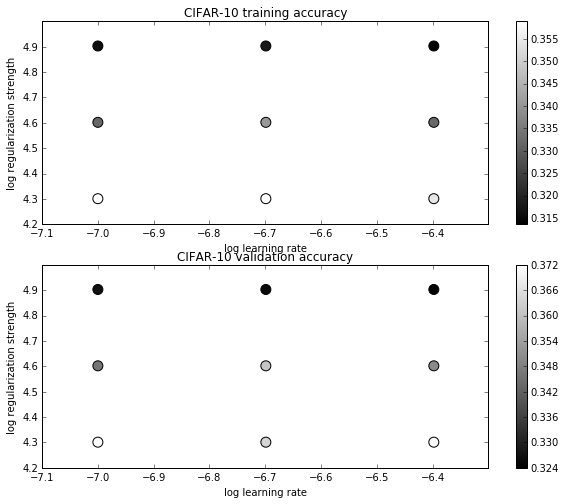

In [62]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [63]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print 'softmax on raw pixels final test set accuracy: %f' % (test_accuracy, )

softmax on raw pixels final test set accuracy: 0.364000


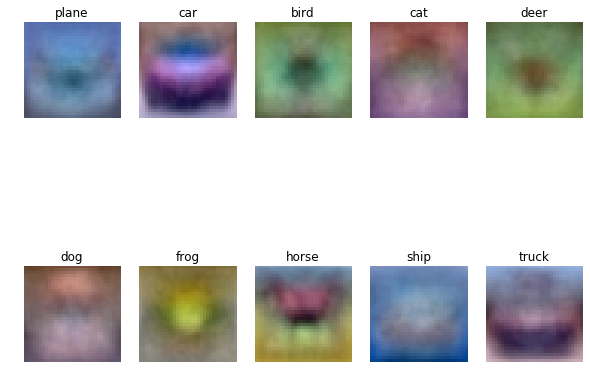

In [64]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
  
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])